<b><font color="SteelBlue" size="+3">Classifiez automatiquement des biens de consommation</font></b>

# Introduction

Ce notebook est la suite de celui sur le traitement des descriptions. On récupère les données nettoyées pour les catégories des produits.

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plot_keras_history import show_history, plot_history

# Traitement images
from matplotlib.image import imread
import time
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from keras.applications import InceptionResNetV2, DenseNet201, EfficientNetB7
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inceptionresnetv2
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet201
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnetb7
from PIL import Image as PilImage
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

# Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# ML
#from sklearn import cluster, metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score

# perso
from Deveau_Estelle_4_IMG_func_042024 import *

In [2]:
print("Version de TensorFlow installée : ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Version de TensorFlow installée :  2.16.1
Num GPUs Available:  0


## Data

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_txt_pretraitement_feature_extraction_faisaibilite_042024.ipynb',
 'Deveau_Estelle_2_NLP_func_042024.py',
 'Deveau_Estelle_3_notebook_img_pretraitement_feature_extraction_faisaibilite_042024.ipynb',
 'Deveau_Estelle_4_IMG_func_042024.py',
 'model1_best.weights.h5',
 'model2_best.weights.h5',
 'model3_best.weights.h5',
 'model_inceptionresnetv2_best.weights.h5',
 'model_vgg16_best.weights.h5',
 'OC_projet6.pptx',
 'pythonProject',
 'standard.png',
 'standard2.png',
 'standard3.png',
 'svg',
 'Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 'Weather_Images_CNN_Transfer_Learning_Stage_2_supervised_classification_V1.0.ipynb',
 '__pycache__']

In [4]:
os.listdir("data/Cleaned/")

['data.csv']

In [5]:
path     = "./data/Cleaned/"
filename = "data.csv"

In [6]:
data = pd.read_csv(path + filename)

In [7]:
path     = "./data/Sources/Images/"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

1050


# Exploration des données

## Quick tour

In [8]:
data.head()

uniq_id product_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7  Home Furnishing   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

In [9]:
data.shape

(1050, 3)

In [10]:
data.dtypes.value_counts()

object    3
Name: count, dtype: int64

In [11]:
data.nunique()

uniq_id             1050
product_category       7
description         1050
dtype: int64

In [12]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 0.0 %


In [13]:
# Liste de toutes les colonnes à conserver
cols_to_keep = ['uniq_id', 'product_category']

In [14]:
df = data[cols_to_keep]

In [15]:
df.head(5)

uniq_id product_category
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care
3  d4684dcdc759dd9cdf41504698d737d8  Home Furnishing
4  6325b6870c54cd47be6ebfbffa620ec7  Home Furnishing

In [16]:
print("Valeurs uniques pour product_category dans df:", df['product_category'].unique())

Valeurs uniques pour product_category dans df: ['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


## Exemples d'images

In [17]:
def get_images_for_category(category, num_images=3):
    """Récupère les noms de fichiers des images pour une catégorie donnée."""
    category_ids = df[df['product_category'] == category]['uniq_id']
    category_images = [f"{id}.jpg" for id in category_ids if f"{id}.jpg" in list_photos]
    return category_images[:num_images]

Catégorie : Home Furnishing


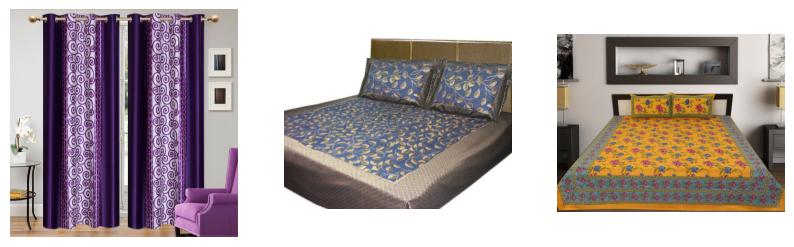

Catégorie : Baby Care


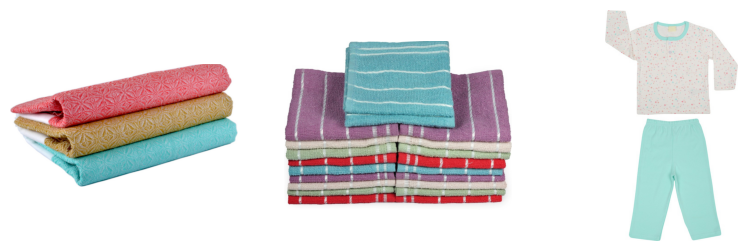

Catégorie : Watches


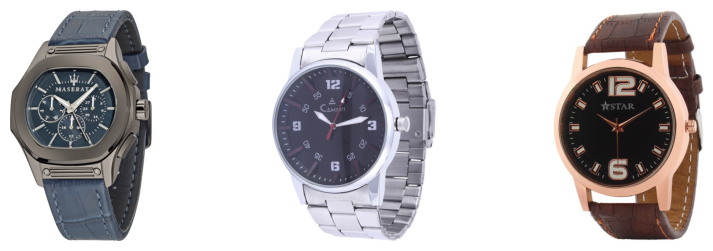

Catégorie : Home Decor & Festive Needs


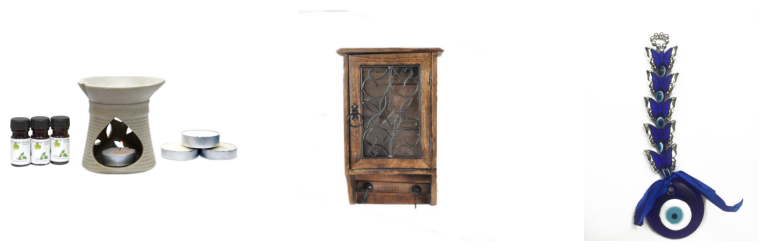

Catégorie : Kitchen & Dining


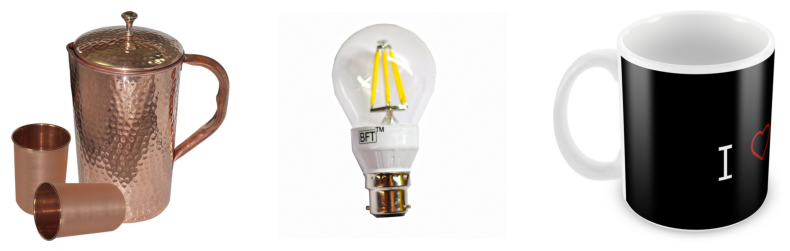

Catégorie : Beauty and Personal Care


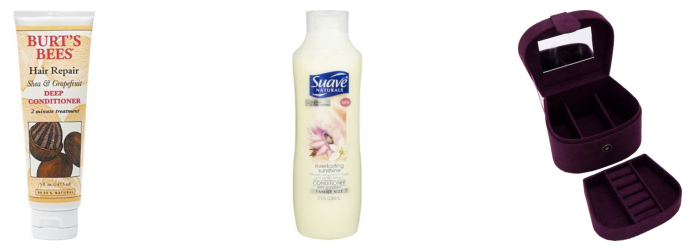

Catégorie : Computers


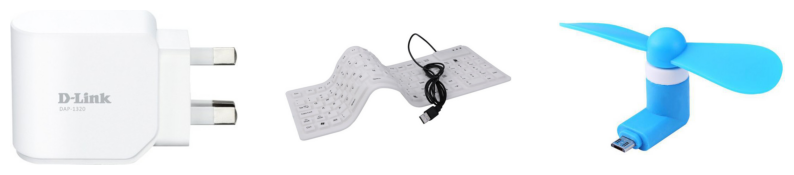

In [18]:
# Affichage des images
for category in df['product_category'].unique():
    print(f"Catégorie : {category}")
    category_images = get_images_for_category(category, 3)
    plt.figure(figsize=(10, 3)) 
    for i, image_name in enumerate(category_images):
        plt.subplot(1, 3, i+1)  
        filename = os.path.join(path, image_name)
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off') 
    plt.show()

# Etude de faisabilité

## Pré-traitements des Images avec SIFT

### Détermination des descripteurs

#### Sur une image

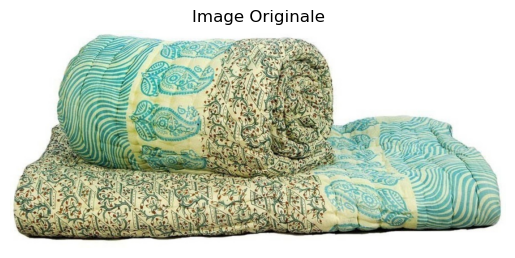

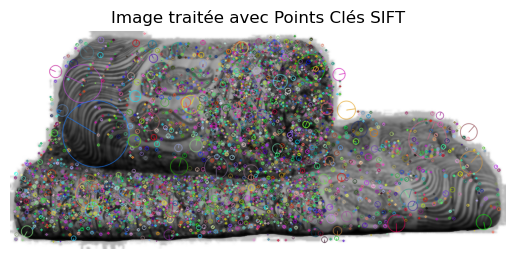

Descripteurs :  (3946, 128)
[[ 40.   2.   2. ...   0.   0.   1.]
 [134.  16.   0. ...   0.   4.   3.]
 [ 44.  91.   8. ...   0.   0.   4.]
 ...
 [  7.   5.  37. ...   0.   1.   6.]
 [ 17.   0.   0. ...   0.   0.   2.]
 [132.  81.   0. ...   0.   0.   1.]]


In [19]:
# Chemin de l'image
image_path = path + list_photos[1000]
original_image = cv2.imread(image_path)
plt_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.title("Image Originale")
plt.imshow(plt_image)
plt.axis('off')
plt.show()

# Traitement de l'image avec la fonction process_image
keypoints, descriptors, processed_image = process_image(image_path)

# Affichage des points clés sur l'image
if descriptors is not None:
    display_keypoints(processed_image, keypoints, "Image traitée avec Points Clés SIFT")
    print("Descripteurs : ", descriptors.shape)
    print(descriptors)
else:
    print("Aucun descripteur trouvé.")

#### Sur chaque image

In [20]:
# Initialisation du temps
temps1 = time.time()

image_paths = [f"{path}{uid}.jpg" for uid in df['uniq_id']]

sift_keypoints_by_img, sift_keypoints_all = process_images_concurrently(image_paths)

duration1 = time.time() - temps1

print("Dimensions des descripteurs par image :", sift_keypoints_by_img.shape)
print("Nombre total de descripteurs :", sift_keypoints_all.shape)
print("Temps de traitement des descripteurs SIFT : ", "{:.2f}".format(duration1), "secondes")

Dimensions des descripteurs par image : (1050,)
Nombre total de descripteurs : (2961542, 128)
Temps de traitement des descripteurs SIFT :  111.07 secondes


### Création des clusters de descripteurs

In [21]:
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42, n_init=10)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("Temps de traitement kmeans : ", "{:.2f}".format(duration1), "secondes")

Nombre de clusters estimés :  1721
Création de 1721 clusters de descripteurs ...
Temps de traitement kmeans :  91.66 secondes


### Création des features des images

In [22]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("Temps de traitement kmeans : ", "{:.2f}".format(duration1), "secondes")

0
100
200
300
400
500
600
700
800
900
1000
Temps de traitement kmeans :  52.14 secondes


### Réduction de dimension

#### ACP

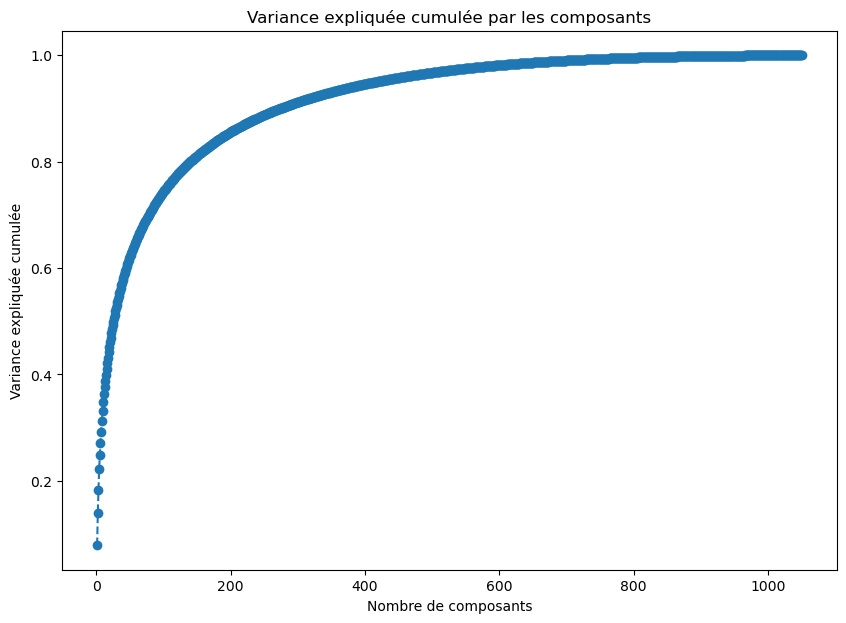

In [23]:
# Création de l'ACP
pca = PCA()

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(im_features)

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [24]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

print(f"Nombre de composantes pour atteindre 99% de variance expliquée : {n_components_99}")

Nombre de composantes pour atteindre 99% de variance expliquée : 699


In [25]:
# PCA
pca = PCA(n_components=n_components_99, svd_solver='randomized', random_state=42)
reduced_im_features = pca.fit_transform(im_features)

#### T-SNE

In [26]:
# Encodage des catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['product_category'])
category_names = label_encoder.classes_

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.011853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.064194
[t-SNE] KL divergence after 1000 iterations: 1.867219


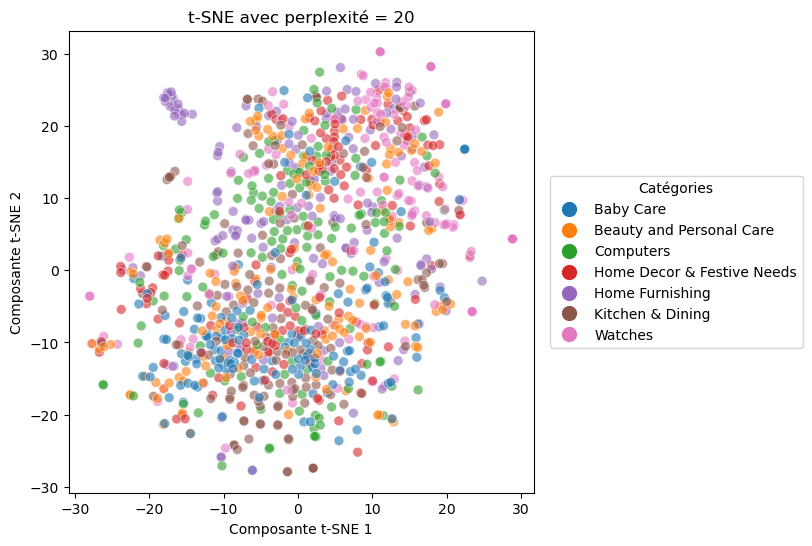

In [27]:
plot_tsne(reduced_im_features, categories_encoded, category_names, 20)

In [28]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, random_state=42)
tsne_reduced_im_features = tsne.fit_transform(reduced_im_features)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.011853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.064194
[t-SNE] KL divergence after 1000 iterations: 1.867219


## Pré-traitement des images avec CNN

In [29]:
def extract_features(image_paths, model, target_size, preprocess_function):
    features_list = []
    for img_path in image_paths:
        processed_image = image_prep_fct([img_path], preprocess_function, target_size) 
        feature = model.predict(processed_image, verbose=0)
        features_list.append(feature.flatten())
    return np.array(features_list)

In [30]:
# Chargement des modèles
models = {
    'VGG16': (VGG16(weights='imagenet', include_top=False), (224, 224), preprocess_vgg16),
    'ResNet50': (ResNet50(weights='imagenet', include_top=False), (224, 224), preprocess_resnet50),
    'InceptionV3': (InceptionV3(weights='imagenet', include_top=False), (299, 299), preprocess_inception_v3),
    'InceptionResNetV2': (InceptionResNetV2(weights='imagenet', include_top=False), (299, 299), preprocess_inceptionresnetv2),
    'DenseNet201': (DenseNet201(weights='imagenet', include_top=False), (224, 224), preprocess_densenet201),
    'EfficientNetB7': (EfficientNetB7(weights='imagenet', include_top=False), (600, 600), preprocess_efficientnetb7)
}

In [31]:
# Définir le seuil à un niveau supérieur spécifique
PilImage.MAX_IMAGE_PIXELS = 100000000

In [32]:
# Extraction des caractéristiques pour chaque modèle et création de DataFrame
dfs = {}
for model_name, (model, size, preprocess) in models.items():
    print(f"Traitement avec {model_name}")
    features = extract_features(image_paths, model, size, preprocess)
    df_features = pd.DataFrame(features)
    dfs[model_name] = df_features
    print(f"DataFrame pour {model_name} créé avec succès.")

Traitement avec VGG16
DataFrame pour VGG16 créé avec succès.
Traitement avec ResNet50
DataFrame pour ResNet50 créé avec succès.
Traitement avec InceptionV3
DataFrame pour InceptionV3 créé avec succès.
Traitement avec InceptionResNetV2
DataFrame pour InceptionResNetV2 créé avec succès.
Traitement avec DenseNet201
DataFrame pour DenseNet201 créé avec succès.
Traitement avec EfficientNetB7
DataFrame pour EfficientNetB7 créé avec succès.


### Réduction de dimension

#### ACP

In [33]:
# Dictionnaire pour stocker les résultats de l'ACP pour chaque modèle
pca_results = {}

for model_name, df_features in dfs.items():
    print(f"Traitement du modèle {model_name}")
    
    # Application de l'ACP pour conserver 99% de la variance
    pca = PCA(n_components=0.99)  # Réglage pour conserver 99% de la variance
    features_pca = pca.fit_transform(df_features)
    
    # Création d'un DataFrame pour les résultats de l'ACP
    df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
    
    # Stockage des résultats dans le dictionnaire
    pca_results[model_name] = df_pca
    
    # Affichage du nombre de composantes utilisées pour atteindre 99% de variance
    print(f"ACP terminée pour {model_name}. Nombre de composantes: {pca.n_components_}")

Traitement du modèle VGG16
ACP terminée pour VGG16. Nombre de composantes: 940
Traitement du modèle ResNet50
ACP terminée pour ResNet50. Nombre de composantes: 976
Traitement du modèle InceptionV3
ACP terminée pour InceptionV3. Nombre de composantes: 961
Traitement du modèle InceptionResNetV2
ACP terminée pour InceptionResNetV2. Nombre de composantes: 922
Traitement du modèle DenseNet201
ACP terminée pour DenseNet201. Nombre de composantes: 952
Traitement du modèle EfficientNetB7
ACP terminée pour EfficientNetB7. Nombre de composantes: 975


#### T-SNE

In [34]:
# Définition des perplexités pour chaque modèle
model_perplexities = {
    'VGG16': 80,
    'ResNet50': 20,
    'InceptionV3': 100,
    'InceptionResNetV2' : 20,
    'DenseNet201' : 100,
    'EfficientNetB7' : 40
}

Applying t-SNE to VGG16
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.003s...
[t-SNE] Computed neighbors for 1050 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 602.160504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.877068
[t-SNE] KL divergence after 1000 iterations: 1.403108


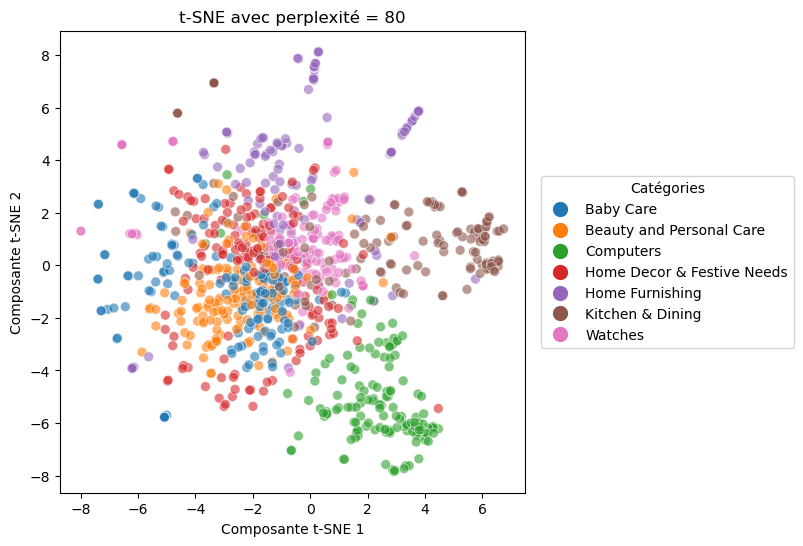

Applying t-SNE to ResNet50
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.003s...
[t-SNE] Computed neighbors for 1050 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 154.249660
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.956612
[t-SNE] KL divergence after 1000 iterations: 1.589340


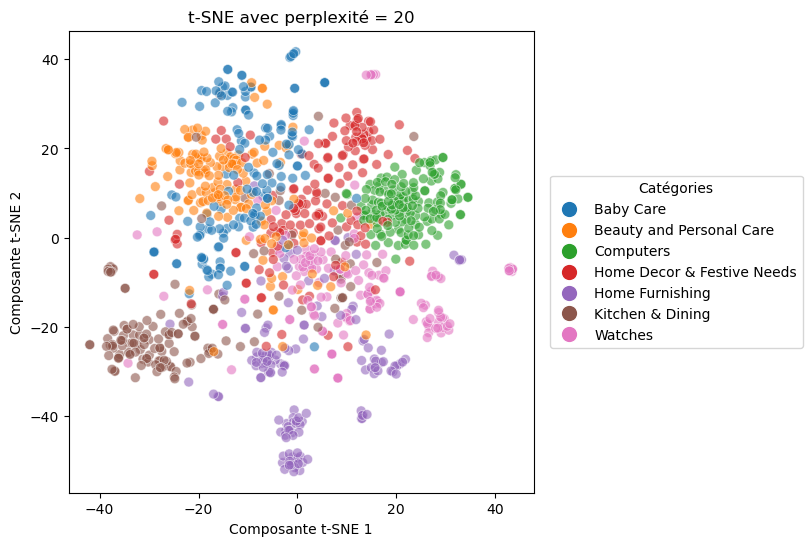

Applying t-SNE to InceptionV3
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 72.462389
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.569950
[t-SNE] KL divergence after 1000 iterations: 1.208183


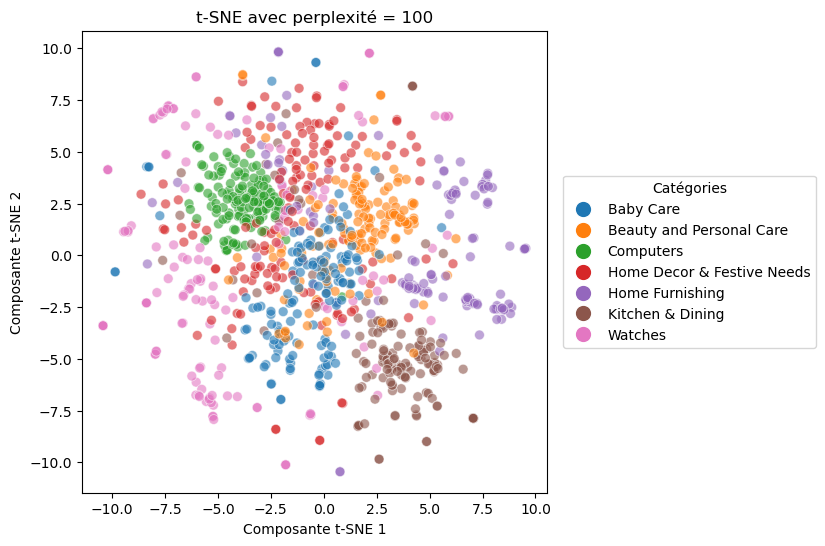

Applying t-SNE to InceptionResNetV2
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 45.972026
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.711967
[t-SNE] KL divergence after 1000 iterations: 1.510891


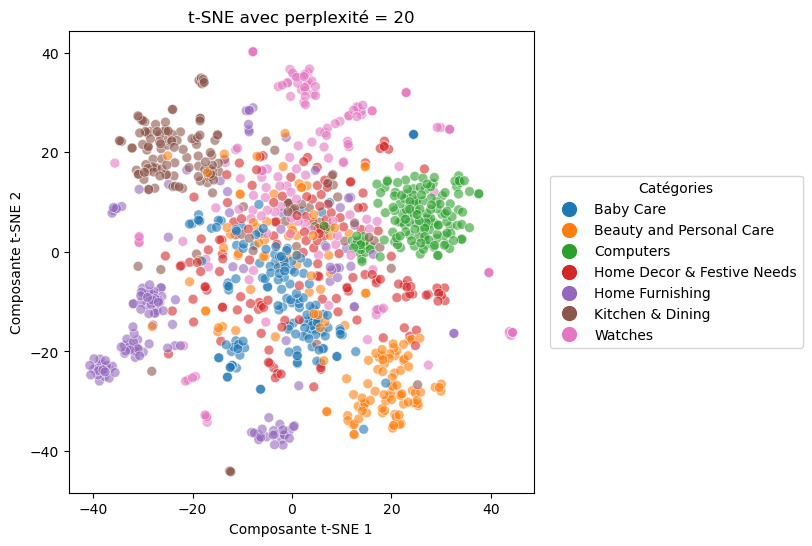

Applying t-SNE to DenseNet201
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 92.879087
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.167957
[t-SNE] KL divergence after 1000 iterations: 1.073657


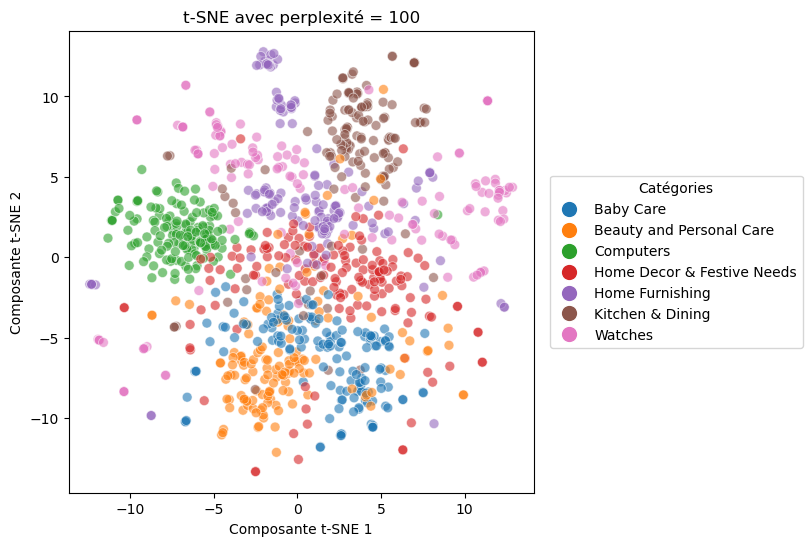

Applying t-SNE to EfficientNetB7
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 126.394588
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.611572
[t-SNE] KL divergence after 1000 iterations: 1.677346


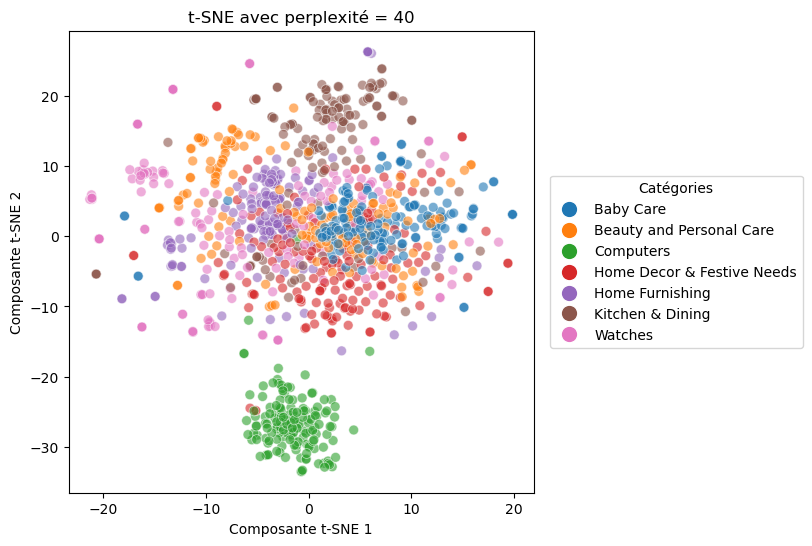

In [35]:
for model_name, df_pca in pca_results.items():
    pca_features = df_pca.copy()
    # Convertir les noms des colonnes en strings si nécessaire
    pca_features.columns = pca_features.columns.astype(str)
    print(f"Applying t-SNE to {model_name}")
    plot_tsne(pca_features, categories_encoded, category_names,perplexity=model_perplexities[model_name])

In [36]:
tsne_results = {}  # Dictionnaire pour stocker les résultats de t-SNE pour chaque modèle

for model_name, df_pca in pca_results.items():
    # Création de l'objet t-SNE avec la perplexité spécifique au modèle
    tsne = TSNE(n_components=2, verbose=1, perplexity=model_perplexities[model_name], random_state=42)
    
    # Application de t-SNE aux caractéristiques réduites par PCA
    tsne_results[model_name] = tsne.fit_transform(df_pca)
    
    print(f"t-SNE terminé pour {model_name} avec perplexité {model_perplexities[model_name]}")

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 602.160504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.877068
[t-SNE] KL divergence after 1000 iterations: 1.403108
t-SNE terminé pour VGG16 avec perplexité 80
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 154.249660
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.956612
[t-SNE] KL divergence after 1000 iterations: 1.589340
t-SNE terminé pour ResNet50 avec perplexité 20
[t-SNE] Computing 301 nearest neighb

## K-means

In [37]:
# Nombre de clusters
n_clusters = 7

### Sur SIFT

Silhouette Score: 0.3628
Adjusted Rand Score: 0.0436
Accuracy: 0.2629


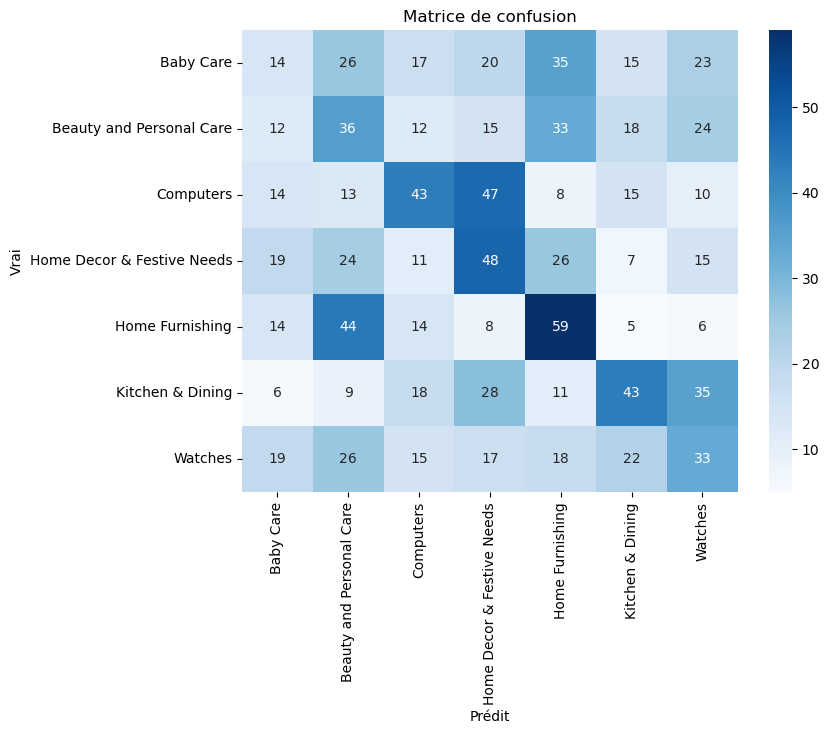

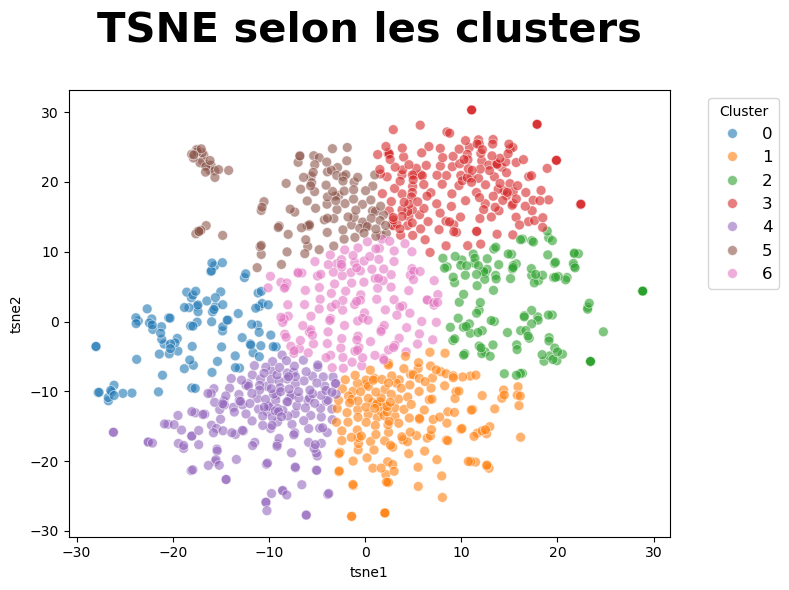

In [38]:
kmeans_metrics_sift = perform_kmeans(X_data=tsne_reduced_im_features, true_labels=categories_encoded, label_names=category_names,
                                n_clusters=n_clusters, random_state=42)

### Sur CNN

Applying K-means to t-SNE results of VGG16
Silhouette Score: 0.3997
Adjusted Rand Score: 0.2957
Accuracy: 0.5581


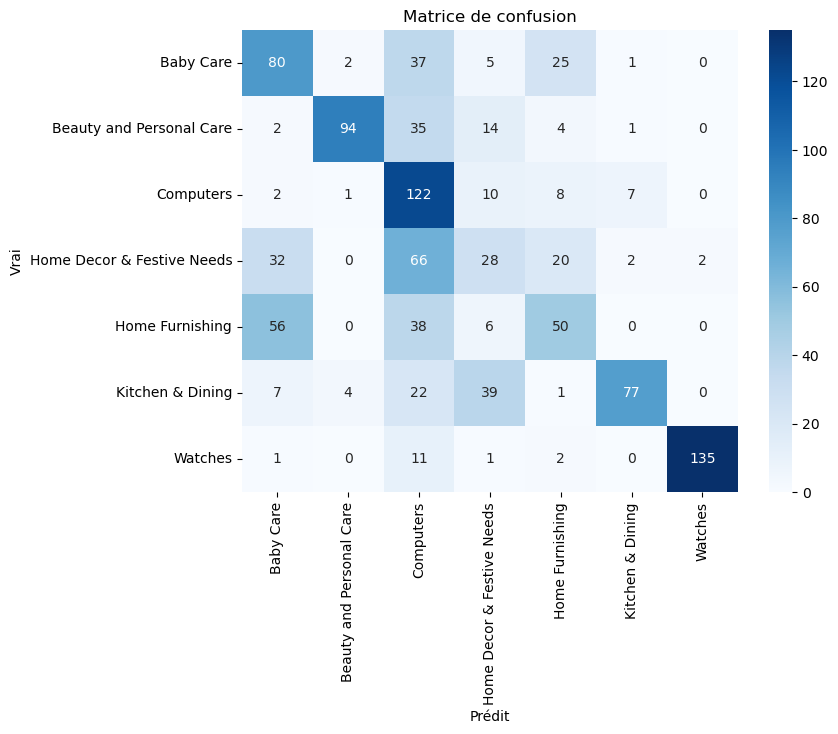

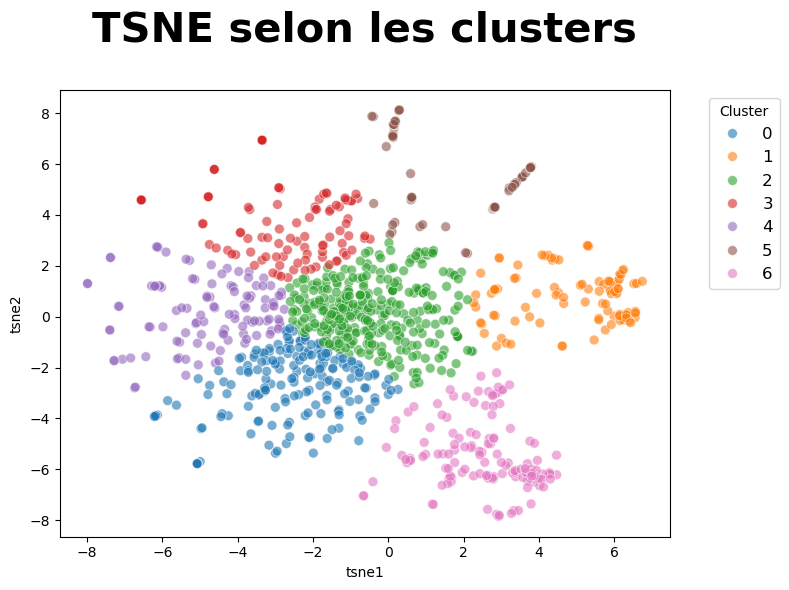

Applying K-means to t-SNE results of ResNet50
Silhouette Score: 0.4049
Adjusted Rand Score: 0.3996
Accuracy: 0.6267


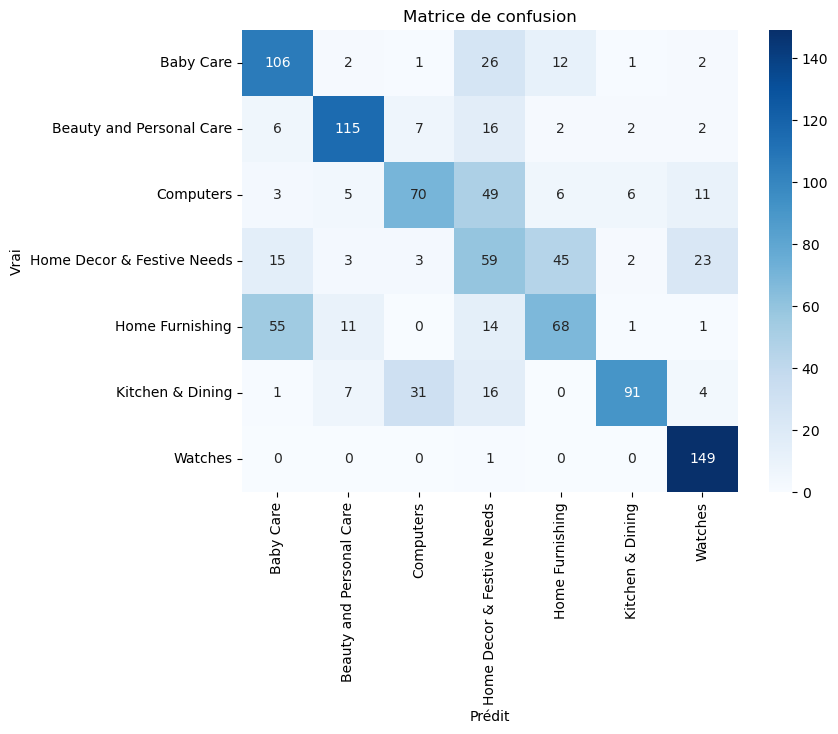

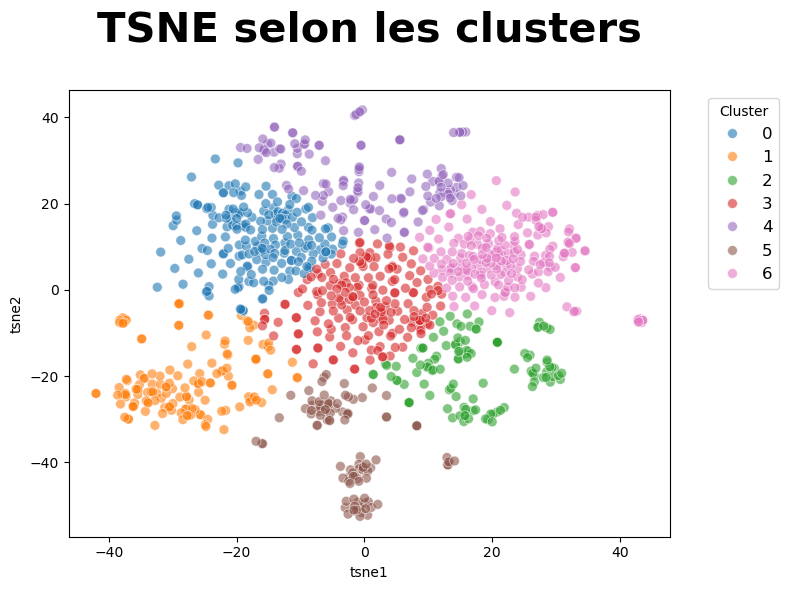

Applying K-means to t-SNE results of InceptionV3
Silhouette Score: 0.3623
Adjusted Rand Score: 0.3293
Accuracy: 0.5543


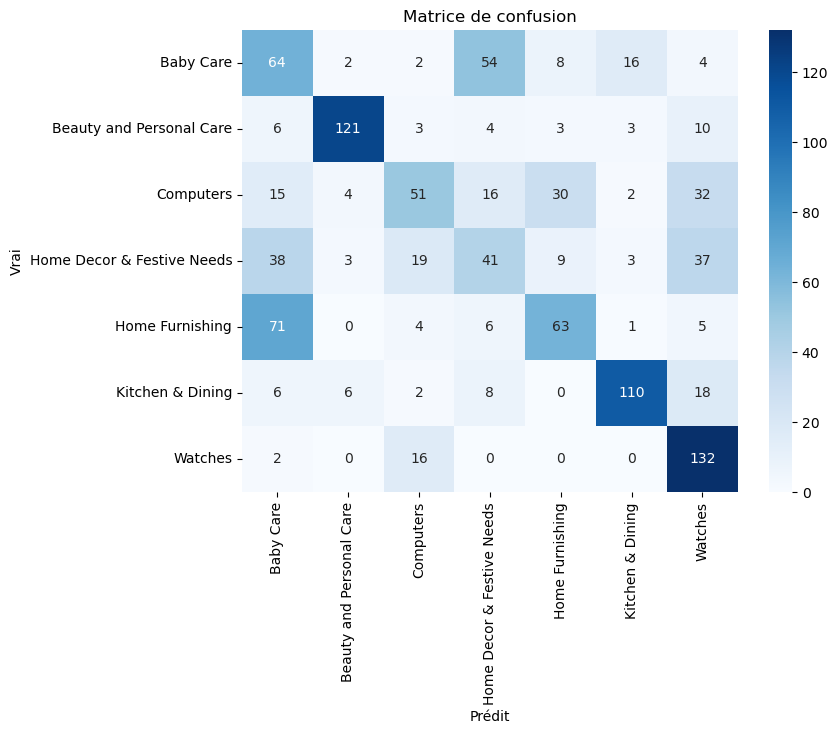

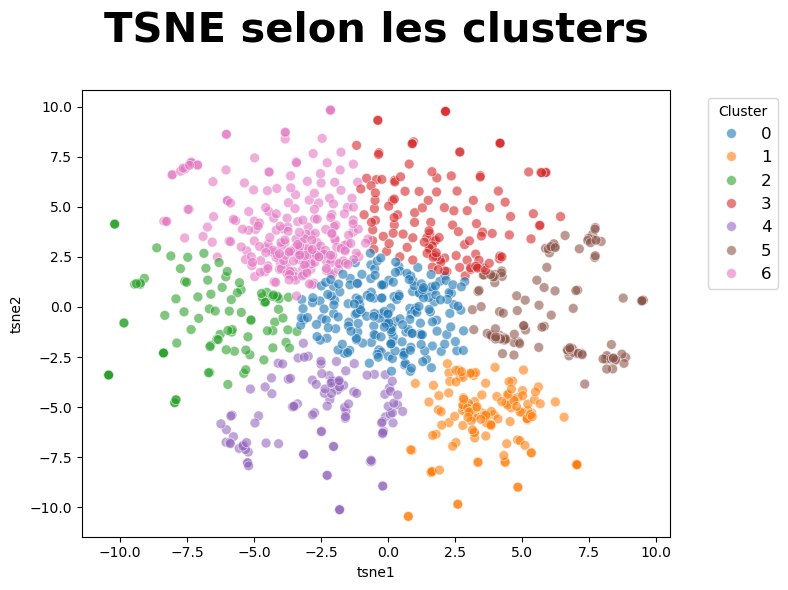

Applying K-means to t-SNE results of InceptionResNetV2
Silhouette Score: 0.4234
Adjusted Rand Score: 0.3281
Accuracy: 0.5867


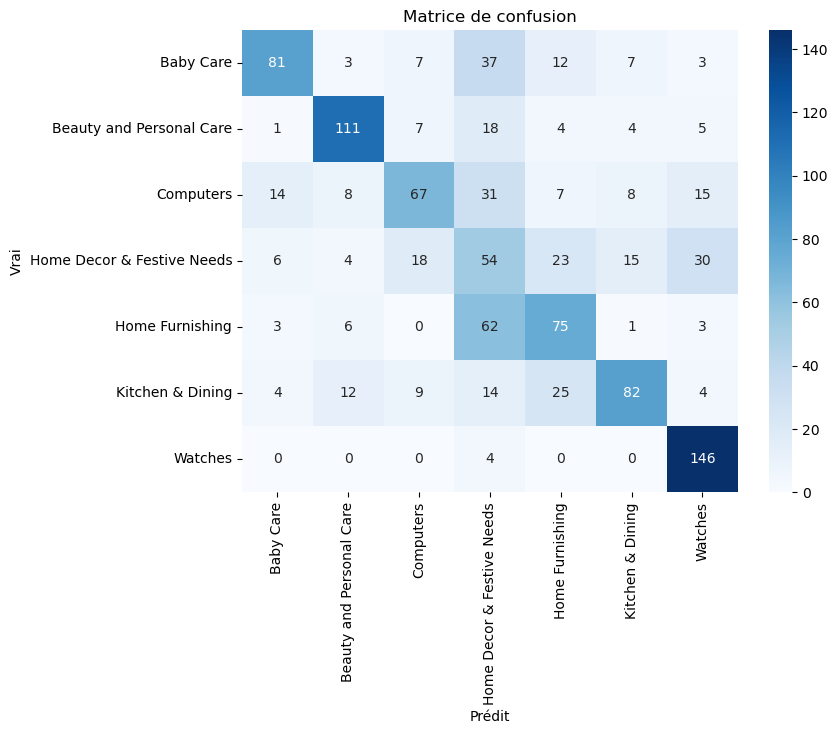

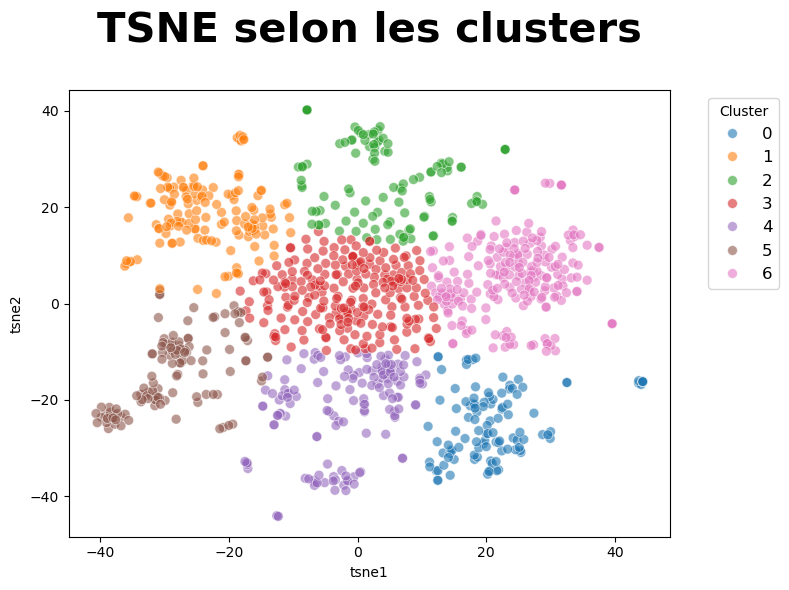

Applying K-means to t-SNE results of DenseNet201
Silhouette Score: 0.4022
Adjusted Rand Score: 0.3941
Accuracy: 0.6105


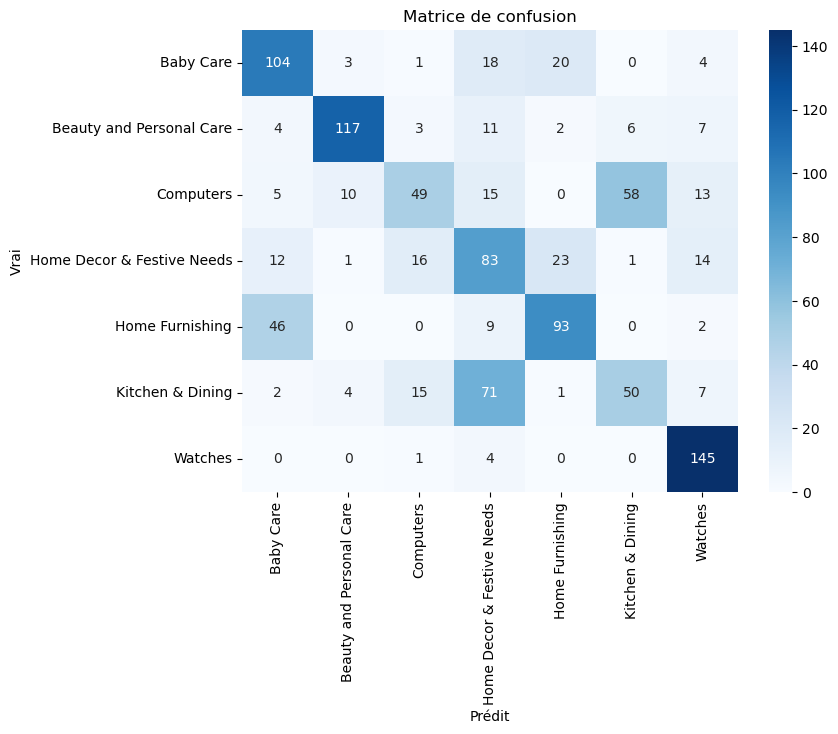

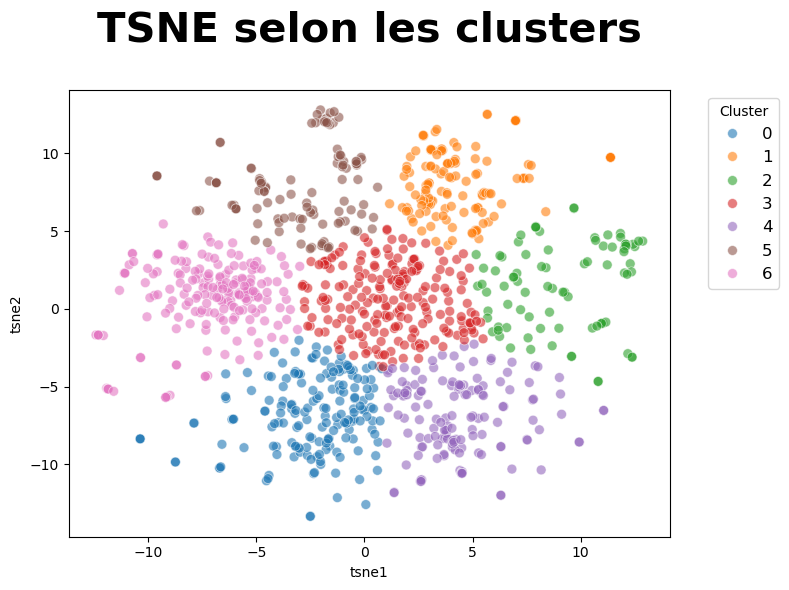

Applying K-means to t-SNE results of EfficientNetB7
Silhouette Score: 0.4200
Adjusted Rand Score: 0.3357
Accuracy: 0.5857


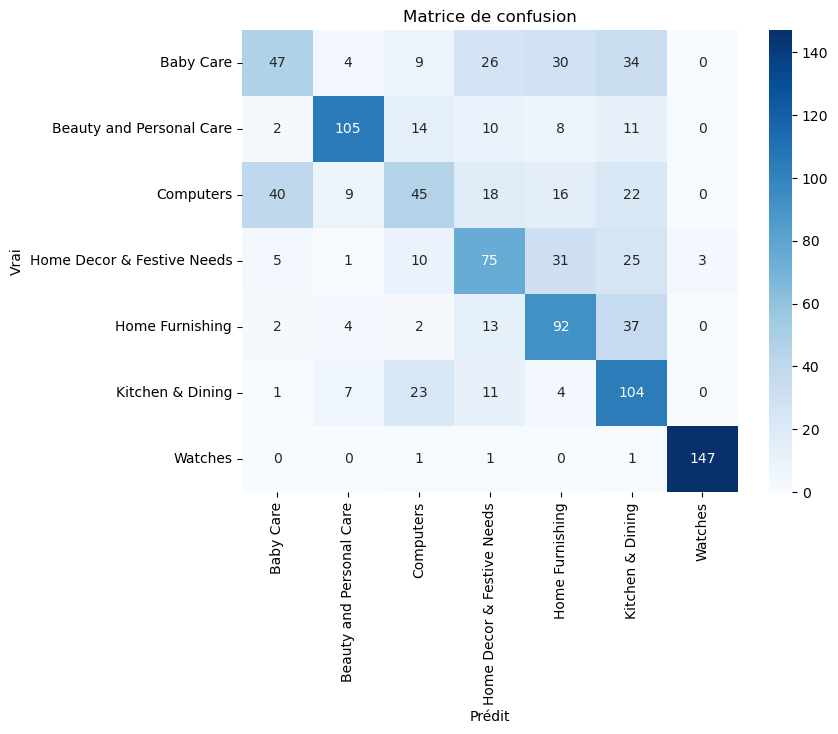

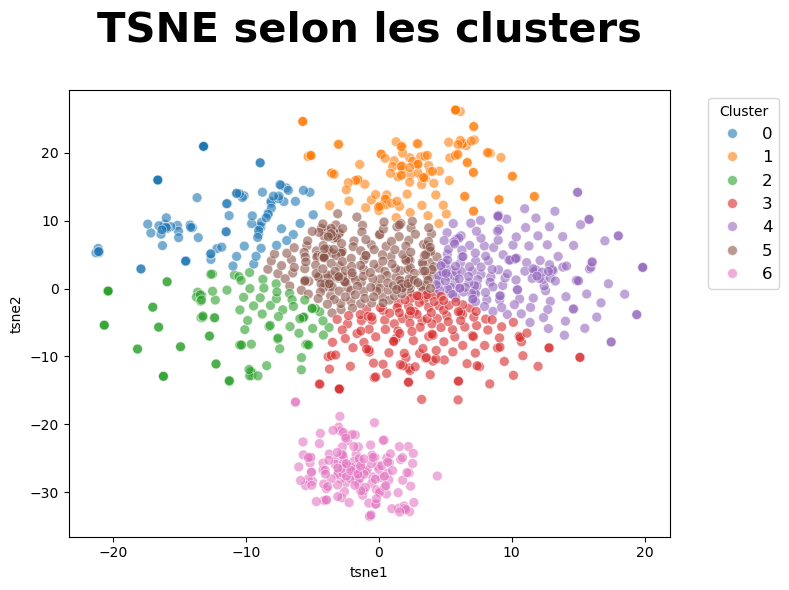

In [39]:
# Dictionnaire pour stocker les métriques de chaque modèle
kmeans_metrics = {}

for model_name, tsne_data in tsne_results.items():
    print(f"Applying K-means to t-SNE results of {model_name}")
    metrics = perform_kmeans(
        X_data=tsne_data, 
        true_labels=categories_encoded,
        label_names=category_names,
        n_clusters=n_clusters,
        random_state=42
    )
    
    # Stocker les métriques pour chaque modèle
    kmeans_metrics[model_name] = metrics

### Comparaison des résultats

In [40]:
# concaténation des resultats
all_metrics = {
    'SIFT': kmeans_metrics_sift,
    **kmeans_metrics
}

# Consolidation des données
data = []
for method, metrics_dict in all_metrics.items():
    for metric_name, value in metrics_dict.items():
        data.append({
            'Method': method,
            'Metric': metric_name,
            'Score': value
        })

data_metrics = pd.DataFrame(data)

In [41]:
data_metrics.head(5)

Method               Metric     Score
0   SIFT     Silhouette Score  0.362845
1   SIFT  Adjusted Rand Score  0.043612
2   SIFT             Accuracy  0.262857
3  VGG16     Silhouette Score  0.399748
4  VGG16  Adjusted Rand Score  0.295715

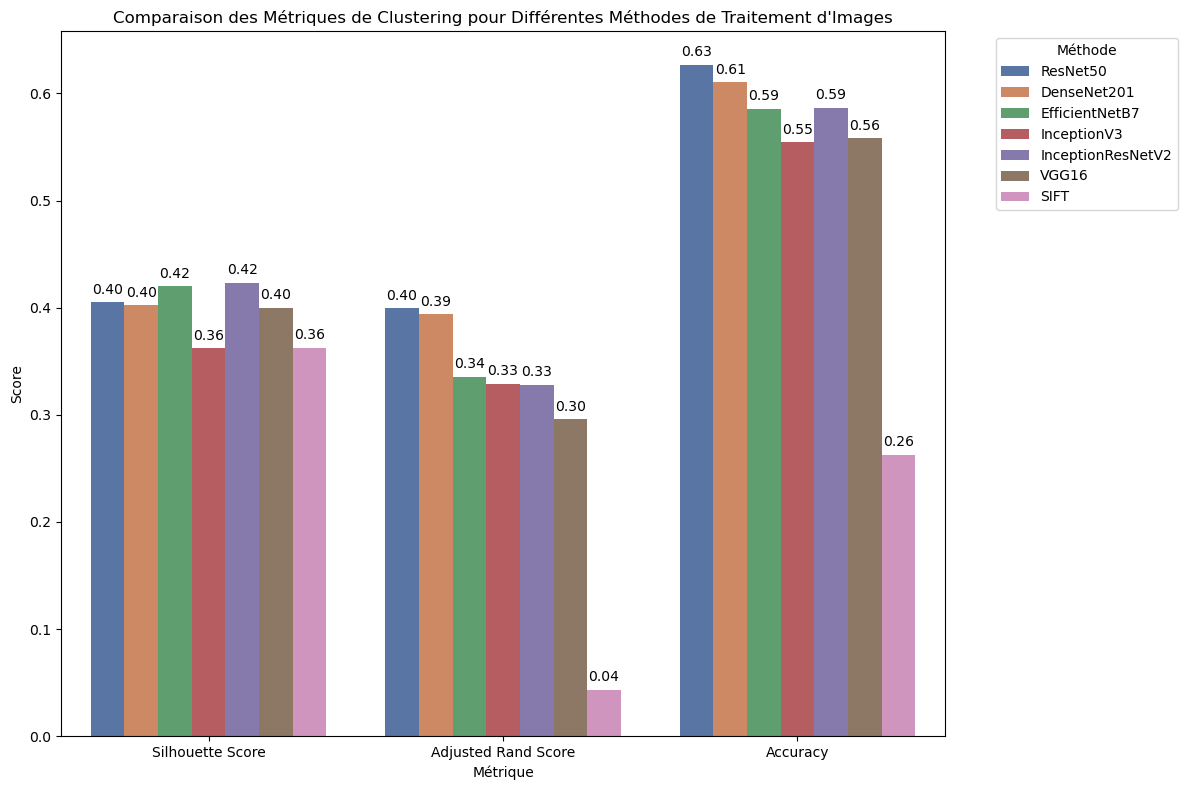

In [42]:
# Trier les données pour la visualisation
sorted_methods = data_metrics[data_metrics['Metric'] == 'Adjusted Rand Score'].sort_values(by='Score', ascending=False)['Method'].unique()

# Assurer l'ordre des méthodes dans le DataFrame pour le graphique
data_metrics['Method'] = pd.Categorical(data_metrics['Method'], categories=sorted_methods, ordered=True)
data_metrics = data_metrics.sort_values('Method')

# Création du graphique
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=data_metrics, x='Metric', y='Score', hue='Method', palette='deep')

# Ajouter des valeurs de score sur les barres pour une meilleure lisibilité
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')

# Configuration finale
plt.title('Comparaison des Métriques de Clustering pour Différentes Méthodes de Traitement d\'Images')
plt.xlabel('Métrique')
plt.ylabel('Score')
plt.legend(title='Méthode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Classification supervisée

In [43]:
def create_model_fct(base_model_name='VGG16'):
    """
    Crée et compile un modèle de classification d'images basé sur un modèle CNN pré-entraîné.
    
    Args:
    - base_model_name (str): Nom du modèle CNN pré-entraîné à utiliser.
    
    Returns:
    - model: Le modèle Keras compilé.
    """
    
    # Sélection du modèle de base en fonction du nom fourni
    if base_model_name == 'InceptionResNetV2':
        base_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
    elif base_model_name == 'DenseNet201':
        base_model = DenseNet201(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    else:  # Le modèle par défaut est VGG16 si aucun nom valide n'est fourni
        base_model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # extraction des features
    for layer in base_model.layers:
        layer.trainable = False

    # Construction du modèle
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définition du nouveau modèle
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    
    # Affichage du résumé du modèle
    model.summary()
    
    return model

## Préparation des images

In [44]:
y = to_categorical(categories_encoded, 7)

In [45]:
y[:5]

array([[0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]])

In [46]:
# Diviser les chemins d'image et les étiquettes
paths_train, paths_test, y_train, y_test = train_test_split(image_paths, y, test_size=0.2, random_state=42)
paths_train, paths_val, y_train, y_val = train_test_split(paths_train, y_train, test_size=0.25, random_state=42)

In [47]:
y_test[:5]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [48]:
# Dictionnaire pour stocker les résultats
results = {}

### VGG16

In [49]:
# Préparation des données
X_train_vgg16, X_val_vgg16, X_test_vgg16 = prepare_data(paths_train, paths_val, paths_test, preprocess_vgg16,
                                                        target_size=(224, 224))

In [50]:
# Création du modèle
model_vgg16 = create_model_fct(base_model_name='VGG16')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [51]:
# Entraînement du modèle
model_vgg16, history_vgg16 = train_model(model_vgg16, X_train_vgg16, y_train, X_val_vgg16, y_val,
                                         model_save_path="./model_vgg16_best.weights.h5")

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3300 - loss: 8.4013
Epoch 1: val_loss improved from inf to 1.56109, saving model to ./model_vgg16_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.3406 - loss: 8.1735 - val_accuracy: 0.7143 - val_loss: 1.5611
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6679 - loss: 2.0442
Epoch 2: val_loss improved from 1.56109 to 1.31869, saving model to ./model_vgg16_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6688 - loss: 2.0443 - val_accuracy: 0.7429 - val_loss: 1.3187
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7278 - loss: 1.6187
Epoch 3: val_loss improved from 1.31869 to 1.27267, saving model to ./model_vgg16_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7272 - loss: 1.6169 - val_accuracy: 0.7476 - val_loss: 1.2727
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7973 - loss: 0.9216
Epoch 4: val_loss improved from 1

In [52]:
# Évaluation du modèle
loss_vgg16, accuracy_vgg16, ari_score_vgg16 = evaluate_model(model_vgg16, X_train_vgg16, y_train, X_val_vgg16,
                                                             y_val, X_test_vgg16, y_test, best_weights_path="./model_vgg16_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9981 - loss: 0.0093
Training Accuracy after last epoch: 0.9968

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7945 - loss: 0.6854
Test Accuracy after last epoch: 0.8000

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7833 - loss: 0.9471
Validation Accuracy (best epoch): 0.7905
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8091 - loss: 0.7181
Test Accuracy (best epoch): 0.8238
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Adjusted Rand Index (ARI): 0.6634


### InceptionResNetV2

In [53]:
# Préparation des données
X_train_inceptionresnetv2, X_val_inceptionresnetv2, X_test_inceptionresnetv2 = prepare_data(paths_train, paths_val,
                                                                                            paths_test, preprocess_inceptionresnetv2,
                                                                                            target_size=(299, 299))

In [54]:
# Création du modèle
model_inceptionresnetv2 = create_model_fct(base_model_name='InceptionResNetV2')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_297 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_297[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_297      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_298 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_297[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_298[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_298      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_299 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_298[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_299[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_299      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 73, 73,    │          0 │ activation_299[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_300 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_300[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_300      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_301 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_300[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_301[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_301      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 54,732,007 (208.79 MB)

 Trainable params: 395,271 (1.51 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [55]:
# Entraînement du modèle
model_inceptionresnetv2, history_inceptionresnetv2 = train_model(model_inceptionresnetv2, X_train_inceptionresnetv2, y_train, X_val_inceptionresnetv2, y_val,
                                                                 model_save_path="./model_inceptionresnetv2_best.weights.h5")

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2920 - loss: 2.3328
Epoch 1: val_loss improved from inf to 0.72290, saving model to ./model_inceptionresnetv2_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 76s 7s/step - accuracy: 0.3077 - loss: 2.2830 - val_accuracy: 0.7905 - val_loss: 0.7229
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7904 - loss: 0.6924
Epoch 2: val_loss improved from 0.72290 to 0.48020, saving model to ./model_inceptionresnetv2_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.7907 - loss: 0.6895 - val_accuracy: 0.8524 - val_loss: 0.4802
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8343 - loss: 0.6018
Epoch 3: val_loss improved from 0.48020 to 0.44979, saving model to ./model_inceptionresnetv2_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.8331 - loss: 0.6006 - val_accuracy: 0.8429 - val_loss: 0.4498
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8465 - loss: 0.45

In [56]:
# Évaluation du modèle
loss_inceptionresnetv2, accuracy_inceptionresnetv2, ari_score_inceptionresnetv2 = evaluate_model(model_inceptionresnetv2,
                                                                                                 X_train_inceptionresnetv2,
                                                                                                 y_train, X_val_inceptionresnetv2,
                                                                                                 y_val, X_test_inceptionresnetv2,
                                                                                                 y_test,
                                                                                                 best_weights_path="./model_inceptionresnetv2_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9787 - loss: 0.0602
Training Accuracy after last epoch: 0.9825

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8807 - loss: 0.5430
Test Accuracy after last epoch: 0.8762

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8640 - loss: 0.3834
Validation Accuracy (best epoch): 0.8762
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8882 - loss: 0.3874
Test Accuracy (best epoch): 0.8762
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
Adjusted Rand Index (ARI): 0.7554


### DenseNet201

In [57]:
# Préparation des données
X_train_densenet201, X_val_densenet201, X_test_densenet201 = prepare_data(paths_train, paths_val, paths_test,
                                                                          preprocess_densenet201, target_size=(224, 224))


In [58]:
# Création du modèle
model_densenet201 = create_model_fct(base_model_name='DenseNet201')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,815,559 (71.78 MB)

 Trainable params: 493,575 (1.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [59]:
# Entraînement du modèle
model_densenet201, history_densenet201 = train_model(model_densenet201, X_train_densenet201, y_train, X_val_densenet201, y_val,
                                                     model_save_path="./model_densenet201_best.weights.h5")


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3270 - loss: 2.4556
Epoch 1: val_loss improved from inf to 0.74986, saving model to ./model_densenet201_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.3401 - loss: 2.3997 - val_accuracy: 0.7619 - val_loss: 0.7499
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7900 - loss: 0.6989
Epoch 2: val_loss improved from 0.74986 to 0.58279, saving model to ./model_densenet201_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7909 - loss: 0.6962 - val_accuracy: 0.7952 - val_loss: 0.5828
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8396 - loss: 0.4830
Epoch 3: val_loss improved from 0.58279 to 0.48560, saving model to ./model_densenet201_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8402 - loss: 0.4829 - val_accuracy: 0.8619 - val_loss: 0.4856
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9052 - loss: 0.3759
Epoch 4: val_lo

In [60]:
# Évaluation du modèle
loss_densenet201, accuracy_densenet201, ari_score_densenet201 = evaluate_model(model_densenet201, X_train_densenet201,
                                                                               y_train, X_val_densenet201,
                                                                                y_val, X_test_densenet201, y_test,
                                                                               best_weights_path="./model_densenet201_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9799 - loss: 0.0722
Training Accuracy after last epoch: 0.9762

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8484 - loss: 0.4983
Test Accuracy after last epoch: 0.8476

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8210 - loss: 0.4953
Validation Accuracy (best epoch): 0.8190
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8521 - loss: 0.4383
Test Accuracy (best epoch): 0.8571
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
Adjusted Rand Index (ARI): 0.7145


### ResNet50

In [63]:
# Préparation des données
X_train_ResNet50, X_val_ResNet50, X_test_ResNet50 = prepare_data(paths_train, paths_val, paths_test,
                                                                 preprocess_resnet50, target_size=(224, 224))


In [64]:
# Création du modèle
model_ResNet50 = create_model_fct(base_model_name='ResNet50')


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [65]:
# Entraînement du modèle
model_ResNet50, history_ResNet50 = train_model(model_ResNet50, X_train_ResNet50, y_train, X_val_ResNet50, y_val,
                                               model_save_path="./model_ResNet50_best.weights.h5")


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2809 - loss: 10.8299
Epoch 1: val_loss improved from inf to 1.64663, saving model to ./model_ResNet50_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.2901 - loss: 10.5001 - val_accuracy: 0.7095 - val_loss: 1.6466
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5904 - loss: 2.8242
Epoch 2: val_loss improved from 1.64663 to 1.19639, saving model to ./model_ResNet50_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5923 - loss: 2.8032 - val_accuracy: 0.7857 - val_loss: 1.1964
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7288 - loss: 1.4983
Epoch 3: val_loss improved from 1.19639 to 1.03451, saving model to ./model_ResNet50_best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7279 - loss: 1.5037 - val_accuracy: 0.8143 - val_loss: 1.0345
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7926 - loss: 1.0935
Epoch 4: val_loss impr

In [66]:
# Évaluation du modèle
loss_ResNet50, accuracy_ResNet50, ari_score_ResNet50 = evaluate_model(model_ResNet50, X_train_ResNet50,
                                                                      y_train, X_val_ResNet50,
                                                                      y_val, X_test_ResNet50, y_test,
                                                                      best_weights_path="./model_ResNet50_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 1.0000 - loss: 0.0087
Training Accuracy after last epoch: 1.0000

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8573 - loss: 0.7271
Test Accuracy after last epoch: 0.8333

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8248 - loss: 0.8436
Validation Accuracy (best epoch): 0.8333
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8492 - loss: 0.6071
Test Accuracy (best epoch): 0.8333
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Adjusted Rand Index (ARI): 0.6673


### Comparaison des résultats

In [68]:
# Création d'un DataFrame avec les données
data_results = {
    'Model': ['VGG16', 'VGG16', 'VGG16', 'InceptionResNetV2', 'InceptionResNetV2', 'InceptionResNetV2', 
              'DenseNet201', 'DenseNet201', 'DenseNet201', 'ResNet50', 'ResNet50', 'ResNet50'],
    'Metric': ['Loss', 'Accuracy', 'Adjusted Rand Score', 
               'Loss', 'Accuracy', 'Adjusted Rand Score', 
               'Loss', 'Accuracy', 'Adjusted Rand Score',
               'Loss', 'Accuracy', 'Adjusted Rand Score'],
    'Score': [
        loss_vgg16, accuracy_vgg16, ari_score_vgg16,
        loss_inceptionresnetv2, accuracy_inceptionresnetv2, ari_score_inceptionresnetv2,
        loss_densenet201, accuracy_densenet201, ari_score_densenet201,
        loss_ResNet50, accuracy_ResNet50, ari_score_ResNet50
    ]
}

data_metrics = pd.DataFrame(data_results)

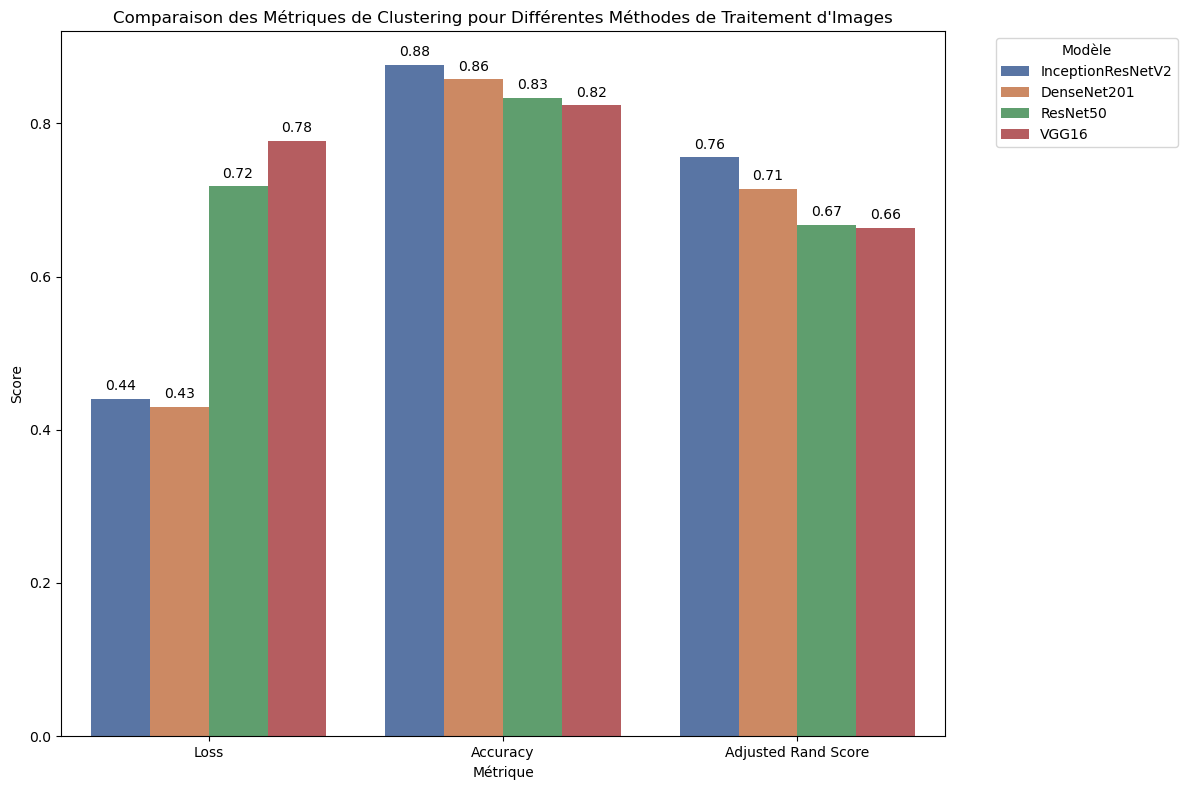

In [69]:
# Trier les données pour la visualisation
sorted_methods = data_metrics[data_metrics['Metric'] == 'Adjusted Rand Score'].sort_values(by='Score', ascending=False)['Model'].unique()

# Assurer l'ordre des méthodes dans le DataFrame pour le graphique
data_metrics['Model'] = pd.Categorical(data_metrics['Model'], categories=sorted_methods, ordered=True)
data_metrics = data_metrics.sort_values('Model')

# Création du graphique
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=data_metrics, x='Metric', y='Score', hue='Model', palette='deep')

# Ajouter des valeurs de score sur les barres pour une meilleure lisibilité
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')

# Configuration finale
plt.title('Comparaison des Métriques de Clustering pour Différentes Méthodes de Traitement d\'Images')
plt.xlabel('Métrique')
plt.ylabel('Score')
plt.legend(title='Modèle', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()